In [1]:
import pickle
import gzip
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from joblib import Parallel, delayed

In [2]:
from utils import *
from preprocessing import Dataset

/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/__init__.py:49: UserWarning: Error loading .pmgrc.yaml: [Errno 2] No such file or directory: '/home/user/.pmgrc.yaml'. You may need to reconfigure your yaml file.
  warnings.warn(f"Error loading .pmgrc.yaml: {ex}. You may need to reconfigure your yaml file.")


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
with gzip.open('data.pickle.gz', 'rb') as fh:
    data = pickle.load(fh, )

In [5]:
dataset = Dataset(data)

In [16]:
class MatrixBuilder:
    def __init__(self, dataset, name):
        self.name = name
        self.group_df = dataset[name].copy()
        self.group_df['distance_graph'] = self.group_df.defect_representation.apply(
            lambda x: nx.from_numpy_matrix(x.distance_matrix)
        )
        self.full_structure = dataset.get_full_structure()
        finder = SpacegroupAnalyzer(self.full_structure,
                                    symprec=1e-1)
        self.checker = finder.get_space_group_operations()
        self.metrics = {"n_symmetry_checks" : 0,
                        "n_find_sym_idx": 0,
                        "sum_len_to_search": 0}
#         self.structure_graph = dataset.get_structure_graph()
#         self.group_df["subgraph"] = self.group_df.defect_representation.apply(
#             lambda x: make_subgraph(self.structure_graph, 
#                                     self.full_structure, 
#                                     x))
        
    def reset_metrics(self):
        self.metrics = {"n_symmetry_checks" : 0,
                        "n_find_sym_idx": 0,
                        "sum_len_to_search": 0}
        
    def swap_sites(self, structure, defect_site, idx):
        """
        Swap defect site with site in structure by index.
        Works correctly when defect is substitution or vacancy
        """
        defect_species = defect_site.species_string
        site_species = structure[idx].species_string
        if defect_species == site_species:
            return structure.copy(), defect_site
        new_defect_site = PeriodicSite(defect_site.species, 
                                       structure[idx].frac_coords, 
                                       structure[idx].lattice)
        if defect_species != "X0+":
            defect_idx = find_site(structure, defect_site)
            indices_species_map = {idx: defect_species, 
                                   defect_idx: site_species}
            transformation = ReplaceSiteSpeciesTransformation(indices_species_map)
            return transformation.apply_transformation(structure), new_defect_site
        insert_transf = InsertSitesTransformation([site_species],
                                                  [defect_site.frac_coords])
        remove_transf = RemoveSitesTransformation([idx])
        removed_s = remove_transf.apply_transformation(structure)
        return insert_transf.apply_transformation(removed_s), new_defect_site
    
    
    def generate_neighbouring_structures(self, structure, defects, how=None):
        """
        Only one swap.
        """
        def defects_are_eq(d1, d2):
            if how is None:
                return self.checker.are_symmetrically_equivalent(d1, 
                                                            d2, 
                                                            symm_prec=0.01)
            elif how == "DG":
                if not matrices_are_isomofic(d1.distance_matrix, 
                                             d2.distance_matrix):
                    return False
                else:
                    return self.checker.are_symmetrically_equivalent(d1, 
                                                                d2, 
                                                                symm_prec=0.01)
            raise ValueError(f"Undefined comparison style: {how}")
            
        result_structures = []
        defect_reprs = []
        for i, defect_site in enumerate(defects):
            nns = get_nn(structure, defect_site)
            for n_idx in nns:
                new_structure, new_defect_site = self.swap_sites(structure, 
                                                            defect_site, 
                                                            n_idx)
                new_defect_repr = defects.copy()
                new_defect_repr[i] = new_defect_site

                # check if swapped with another defect
                found, idx = safe_find_site(defects, new_defect_site)
                if found:
                    swapped_defect_site = PeriodicSite(defects[idx].species, 
                                       defect_site.frac_coords, 
                                       defect_site.lattice)
                    new_defect_repr[idx] = swapped_defect_site
                # check if got something different from 
                # initial conf and all generated before
                is_new = True
#                 for reprn in defect_reprs+[defects]:
                for reprn in defect_reprs:
                    if defects_are_eq(reprn, new_defect_repr):
                        is_new = False
                        break
                if is_new or len(defect_reprs) == 0:
                    result_structures.append(new_structure)
                    defect_reprs.append(new_defect_repr)
        return result_structures, defect_reprs
    
    def get_similar_by_dg(self, defect_representation, rtol=1e-2):
        DG = nx.from_numpy_matrix(defect_representation.distance_matrix)
        edge_match = iso.numerical_edge_match("weight", 0.0, rtol=rtol)
        match = lambda x: nx.is_isomorphic(x, DG, edge_match=edge_match)
        return self.group_df[np.vectorize(match)(
            self.group_df.distance_graph
        )]

    
    def get_similar_by_sg(self, defect_representation, rtol=0.5):
        SG = make_subgraph(self.structure_graph, 
                           self.full_structure,
                           defect_representation)
        edge_match = iso.numerical_edge_match("weight", 0.0, rtol=rtol)
        node_match = lambda n1, n2: n1["specie"] == n2["specie"]
        match = lambda x: nx.is_isomorphic(x, SG)
        return self.group_df[np.vectorize(match)(
            self.group_df.subgraph
        )]
    
    def get_equivalent_idx(self, defect_representation, how=None):
        self.metrics["n_find_sym_idx"] += 1
        if how is None:
            to_search = self.group_df
        elif how=="DG":
            to_search = self.get_similar_by_dg(defect_representation)
        elif how=="SG":
            to_search = self.get_similar_by_sg(defect_representation)
        self.metrics["sum_len_to_search"] += len(to_search)
        if len(to_search) == 1:
            return to_search.index[0]
        for i, row in to_search.iterrows():
            self.metrics["n_symmetry_checks"] += 1 
            if self.checker.are_symmetrically_equivalent(defect_representation,
                                                    row.defect_representation,
                                                    symm_prec=0.01):
                return i
        raise ValueError(
            f"Not found symmetrically equivalent structure for {defect_representation}"
        )
        
    def _generate_delta_e_dict(self, how=None, n_jobs=1):
        """
        Returns dict with E_dst-E_src (energies of destination and source conf)
        """
        def get_item(i, row):
            adj_dict = {}
            cur_energy = row.energy_per_atom
            ns, defect_reprs = self.generate_neighbouring_structures(
                row.initial_structure, row.defect_representation, how=how)
            adj_dict[i] = {}
            for defect_repr in defect_reprs:
                idx = self.get_equivalent_idx(defect_repr, how)
                energy = self.group_df.loc[idx].energy_per_atom
                if idx != i:
                    adj_dict[i] |= {idx: {"weight": energy - cur_energy}}
            return adj_dict

        result = Parallel(n_jobs=n_jobs, verbose=1000)(
            delayed(get_item)(i, row) for i, row in self.group_df.iterrows()
        )
        adj_dict = {}
        for entry in result:
            adj_dict |= entry
        return adj_dict
        
        
    def generate_group_adj_dict(self, thr=0.0, n_jobs=1, how=None):
        """
        Parallel
        """
        def get_item(i, row):
            adj_dict = {}
            cur_energy = row.energy_per_atom
            ns, defect_reprs = self.generate_neighbouring_structures(
                row.initial_structure, row.defect_representation, how=how)
            adj_dict[i] = []
            for defect_repr in defect_reprs:
                idx = self.get_equivalent_idx(defect_repr, how)
                energy = self.group_df.loc[idx].energy_per_atom
                if energy - cur_energy <= thr:
                    adj_dict[i].append(idx)
            return adj_dict

        result = Parallel(n_jobs=n_jobs, verbose=1000)(
            delayed(get_item)(i, row) for i, row in self.group_df.iterrows()
        )
        adj_dict = {}
        for entry in result:
            adj_dict |= entry
        return adj_dict

In [17]:
%time V5_same_MB = MatrixBuilder(dataset, 'V5_same')

CPU times: user 439 ms, sys: 720 ms, total: 1.16 s
Wall time: 240 ms


In [175]:
structs, defects = V5_same_MB.generate_neighbouring_structures(dataset[27].initial_structure, 
                                                               dataset[27].defect_representation)

In [174]:
%time V5_same_MB.get_equivalent_idx(defects[2], how="DG")

CPU times: user 130 ms, sys: 112 ms, total: 242 ms
Wall time: 84.4 ms


214

In [26]:
V5_same_MB.metrics

{'n_symmetry_checks': 1553, 'n_find_sym_idx': 5806, 'sum_len_to_search': 6843}

In [28]:
V5_same_MB.metrics["sum_len_to_search"] / V5_same_MB.metrics["n_find_sym_idx"]

1.178608336203927

In [29]:
V5_same_MB.metrics["n_symmetry_checks"] / V5_same_MB.metrics["n_find_sym_idx"]

0.2674819152600758

In [24]:
%time ad = V5_same_MB.generate_group_adj_dict(how="DG", n_jobs=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    8.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:   12.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  

[Parallel(n_jobs=1)]: Done 103 out of 103 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 104 out of 104 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 106 out of 106 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 107 out of 107 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 109 out of 109 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 111 out of 111 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 112 out of 112 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 113 out of 113 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 114 out of 114 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 11

[Parallel(n_jobs=1)]: Done 206 out of 206 | elapsed:  4.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 207 out of 207 | elapsed:  4.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 208 out of 208 | elapsed:  4.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 209 out of 209 | elapsed:  4.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:  4.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 211 out of 211 | elapsed:  4.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 212 out of 212 | elapsed:  4.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 213 out of 213 | elapsed:  4.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 214 out of 214 | elapsed:  4.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 215 out of 215 | elapsed:  4.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:  4.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 217 out of 217 | elapsed:  4.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 218 out of 21

[Parallel(n_jobs=1)]: Done 309 out of 309 | elapsed:  6.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 310 out of 310 | elapsed:  6.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:  6.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 312 out of 312 | elapsed:  6.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 313 out of 313 | elapsed:  6.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 314 out of 314 | elapsed:  6.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 315 out of 315 | elapsed:  6.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 316 out of 316 | elapsed:  6.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 317 out of 317 | elapsed:  6.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 318 out of 318 | elapsed:  6.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 319 out of 319 | elapsed:  6.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:  6.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 321 out of 32

In [72]:
graphs = dataset.data.defect_representation.apply(
    lambda x: nx.from_numpy_matrix(x.distance_matrix)
)
graphs[24]

In [12]:
def create_pbmol(defect_representation, title="title"):
    mol = openbabel.OBMol()
    n = len(defect_representation)
    for defect in defect_representation:
        a = mol.NewAtom()
        coords = defect.coords
        atomic_num = defect.specie.Z
        if defect.specie.symbol == 'X':
            atomic_num = 79 # Au is not present in dataset
        a.SetAtomicNum(atomic_num)
        a.SetVector(*coords)
    for i in range(n):
        for j in range(i+1, n, 1):
            mol.AddBond(i+1, j+1, 1)
    mol.SetTitle(title)
    return pybel.Molecule(mol)
        

In [114]:
# dataset.data.where(np.vectorize(same_ecfp)(dataset.data.ecfp2, dataset[24].ecfp2)).dropna()

In [20]:
from e3fp.fingerprint.generate import fp, fprints_dict_from_mol, fprints_dict_from_sdf

In [56]:
def generate_e3fps(group_df, group_name):
    o_file_sdf = pybel.Outputfile("sdf", f"{group_name}_small.sdf", overwrite=True)
    for i, row in group_df.iterrows():
        pbmol = create_pbmol(row.defect_representation, str(i))
        o_file_sdf.write(pbmol)
    o_file_sdf.close()
    fps = []
    for mol in Chem.SDMolSupplier(f"{group_name}_small.sdf"):
        fps.append(fprints_dict_from_mol(mol)[5][0].bits)
    return fps

In [12]:
sample_V5_same_ad = restore_adj_dict('../../Downloads/V5_same')

In [25]:
import deepdiff
diff = deepdiff.DeepDiff(ad, sample_V5_same_ad, 
                         ignore_numeric_type_changes=True, ignore_order=True)
diff

{}

In [18]:
def check_reachable(adj_dict, min_idx):
    is_reachable = True
    digraph = nx.from_dict_of_lists(adj_dict, create_using=nx.DiGraph)
    for node in digraph:
        if not nx.has_path(digraph, node, min_idx):
            print(f"No path from {node} to {min_idx}!")
            is_reachable = False
    return is_reachable

In [141]:
plot3d(Structure.from_sites(get_sites_of_subgraph(graph,full_structure, dataset[2686].defect_representation)))

[53, 61, 6, 71]
[53, 61, 6, 135]
[71, 6, 135]


/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/structure.py:759: UserWarning: Not all sites have property was. Missing values are set to None.
  warnings.warn(f"Not all sites have property {k}. Missing values are set to None.")


NGLWidget()

In [155]:
plot3d(Structure.from_sites(full_structure.sites+defects[1].sites))

/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/structure.py:759: UserWarning: Not all sites have property was. Missing values are set to None.
  warnings.warn(f"Not all sites have property {k}. Missing values are set to None.")


NGLWidget()

In [129]:
edge_match = iso.numerical_edge_match("weight", 0.0, atol=0.7)
node_match = lambda n1, n2: n1["specie"] == n2["specie"]

In [131]:
nx.is_isomorphic(make_subgraph(V5_same_MB.structure_graph, 
                               V5_same_MB.full_structure, 
                               dataset[3082].defect_representation), 
                 make_subgraph(V5_same_MB.structure_graph, 
                               V5_same_MB.full_structure, 
                               defects[1]))

/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/structure.py:759: UserWarning: Not all sites have property was. Missing values are set to None.
  warnings.warn(f"Not all sites have property {k}. Missing values are set to None.")


True

In [153]:
nx.weisfeiler_lehman_graph_hash(g3082)

'b03d2fb11fffb5acdef03c81511cd800'

In [155]:
nx.weisfeiler_lehman_graph_hash(make_subgraph(V5_same_MB.structure_graph, 
                               V5_same_MB.full_structure, 
                               defects[1]))

/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/structure.py:759: UserWarning: Not all sites have property was. Missing values are set to None.
  warnings.warn(f"Not all sites have property {k}. Missing values are set to None.")


'b03d2fb11fffb5acdef03c81511cd800'

In [124]:
g3082 = make_subgraph(V5_same_MB.structure_graph, 
                               V5_same_MB.full_structure, 
                               dataset[3082].defect_representation)
g3082.edges

EdgeView([(0, 2), (1, 6), (2, 3), (3, 7), (4, 5), (4, 7), (5, 6)])

In [126]:
g3082[5][6]

{'to_jimage': (0, 0, 0), 'weight': 3.1903156999999993}

In [99]:
make_subgraph(V5_same_MB.structure_graph, 
                               V5_same_MB.full_structure, 
                               defects[1]).nodes[7]

/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/structure.py:759: UserWarning: Not all sites have property was. Missing values are set to None.
  warnings.warn(f"Not all sites have property {k}. Missing values are set to None.")


{'specie': 'S',
 'coords': array([ 7.97578912, 11.97254266,  5.28463537]),
 'properties': {'was': None}}

In [278]:
dataset[214].defect_representation

Structure Summary
Lattice
    abc : 25.5225256 25.5225256 14.879004
 angles : 90.0 90.0 119.99999999999999
 volume : 8393.668021812642
      A : 25.5225256 0.0 1.5628039641098191e-15
      B : -12.761262799999994 22.10315553833868 1.5628039641098191e-15
      C : 0.0 0.0 14.879004
PeriodicSite: X0+ (9.5837, 1.8346, 3.7198) [0.4170, 0.0830, 0.2500]
PeriodicSite: Se (-3.1903, 20.2612, 2.1549) [0.3333, 0.9167, 0.1448]
PeriodicSite: Se (20.7371, 6.4468, 2.1549) [0.9583, 0.2917, 0.1448]

In [279]:
dataset[215].defect_representation

Structure Summary
Lattice
    abc : 25.5225256 25.5225256 14.879004
 angles : 90.0 90.0 119.99999999999999
 volume : 8393.668021812642
      A : 25.5225256 0.0 1.5628039641098191e-15
      B : -12.761262799999994 22.10315553833868 1.5628039641098191e-15
      C : 0.0 0.0 14.879004
PeriodicSite: W (14.3564, 4.6048, 3.7198) [0.6667, 0.2083, 0.2500]
PeriodicSite: X0+ (20.7243, 0.9283, 2.1575) [0.8330, 0.0420, 0.1450]
PeriodicSite: Se (14.3564, 17.4983, 2.1549) [0.9583, 0.7917, 0.1448]

In [233]:
def make_steiner_tree(structure_graph, full_structure, defect_representation):
    idx = [find_site(full_structure, defect) for defect in defect_representation]
    new_graph = nx.Graph(structure_graph.graph)
    for i, defect in enumerate(defect_representation):
        if defect.specie.symbol == "X":
            node = idx[i]
            for neighbor in new_graph.neighbors(node):
                # vacancies should have degree = 1 in resulting tree
                new_graph[node][neighbor]["weight"] *= 100
    return nx.algorithms.approximation.steiner_tree(new_graph, idx)

In [284]:
full_structure = dataset.get_full_structure()
%time graph = make_graph(full_structure)

CPU times: user 11.7 s, sys: 692 ms, total: 12.4 s
Wall time: 11.3 s


In [11]:
%time subgraphs = dataset.data.defect_representation.apply(make_subgraph)

/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/structure.py:759: UserWarning: Not all sites have property was. Missing values are set to None.
  warnings.warn(f"Not all sites have property {k}. Missing values are set to None.")


CPU times: user 3min 51s, sys: 83.5 ms, total: 3min 51s
Wall time: 3min 52s


In [12]:
dataset.data["subgraph"] = subgraphs

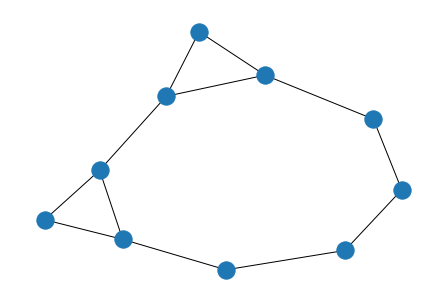

In [21]:
nx.draw(dataset[21].subgraph)

In [15]:
def check_all_groups(groups, data, checker):
    all_adjs = {}
    all_reachability = {}
    for group in tqdm(groups):
        group_df = data[data.group == group]
        all_adjs[group] = generate_group_adj_dict(group_df, checker)
        min_idx = group_df.iloc[group_df.energy_per_atom.argmin()].idx
        all_reachability[group] = check_reachable(all_adjs[group], 
                                                     min_idx)
    return all_adjs, all_reachability

In [16]:
from pymatgen.core.structure import Molecule, Element
from pymatgen.io.babel import BabelMolAdaptor

In [50]:
%time ad = generate_group_adj_dict(dataset['X2'], checker)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-3)]: Done   2 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-3)]: Done   3 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-3)]: Done   4 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-3)]: Done   5 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-3)]: Done   6 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-3)]: Done   7 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-3)]: Done   8 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-3)]: Done   9 out of  19 | elapsed:    8.5s remaining:    9.4s
[Parallel(n_jobs=-3)]: Done  10 out of  19 | elapsed:    9.2s remaining:    8.3s
[Parallel(n_jobs=-3)]: Done  11 out of  19 | elapsed:    9.9s remaining:    7.2s
[Parallel(n_jobs=-3)]: Done  12 out of  19 | elapsed:   10.4s remaining:    6.1s
[Parallel(n_jobs=-3)]: Done  13 out of  19 | elapsed:   10.6s remaining:    4.9s
[Parallel(n_jobs=-3)]: 

In [51]:
ad

{1: [],
 4: [4, 292, 208, 453],
 17: [230, 137, 165],
 45: [672, 769, 230, 17],
 137: [137, 230],
 165: [137],
 208: [208, 1, 582],
 230: [230, 769],
 292: [208],
 370: [1, 582, 597, 370],
 398: [4, 292, 398],
 453: [208, 582],
 500: [4, 453],
 551: [551, 137],
 566: [230, 137, 551],
 582: [1],
 597: [],
 672: [672],
 769: [672]}

In [46]:
dataset['X2_diff'].loc[4]

energy_per_atom                                                  -7.287014
initial_structure        [[1.27612629e-07 1.84192955e+00 3.71975100e+00...
defect_representation    [[ 7.96302799 17.50569919  2.15745558] X0+, [-...
subgroup                                                           X2_diff
group                                                                   X2
Name: 4, dtype: object

In [20]:
def get_fp(defect_representation, fptype='ecfp8'):
    return create_pbmol(defect_representation).calcfp(fptype=fptype)

In [21]:
dataset.data['ecfp8'] = dataset.data.defect_representation.apply(get_fp)

In [123]:
def check_matr_repr(idx):
    ns, defect_reprs = generate_neighbouring_structures(
        dataset[idx].initial_structure, dataset[idx].defect_representation, checker
    )
    for defect_repr in defect_reprs:
        for i, row in dataset[dataset[idx].subgroup].iterrows():
            if checker.are_symmetrically_equivalent(defect_repr,
                                                row.defect_representation,
                                                symm_prec=0.01):
                assert matrices_are_isomofic(row.dist_matr, defect_repr.distance_matrix)
    

In [124]:
check_matr_repr(24)

In [88]:
def with_isomorfic_matr(defect_repr, m2):
    return matrices_are_isomofic(defect_repr.distance_matrix, 
                                 m2)
is24 = dataset.data[np.vectorize(matrices_are_isomofic, excluded=[1])(dataset.data.dist_matr,
                                                 dataset[24].defect_representation.distance_matrix)]

In [89]:
is24

,energy_per_atom,initial_structure,defect_representation,subgroup,group,dist_matr
idx,,,,,,
24,-7.215713,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[3.20307696 7.36035079 3.719751 ] X0+, [23.9...",V5_diff,V5,"[[0.0, 8.181540959822657, 6.819087784854247], ..."
239,-7.282005,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[-3.19031557 12.89350732 3.719751 ] W, [14....",S5_diff,S5,"[[0.0, 8.179869022801043, 6.823051215152787], ..."
1903,-7.289582,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,[[8.50750874e-08 7.36771851e+00 3.71975100e+00...,S6_diff,S6,"[[0.0, 6.8184941833112696, 8.179868856895947],..."
1938,-7.229946,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[15.96433976 12.88613968 3.719751 ] X0+, [1...",V3_diff,V3,"[[0.0, 6.814560204260533, 8.182744596837605], ..."
3574,-7.223203,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[20.74981331 4.59745635 3.719751 ] X0+, [ ...",V6_diff,V6,"[[0.0, 8.182744596837606, 6.819087784854248], ..."
4431,-7.222900,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[11.17886621 10.12324524 3.719751 ] X0+, [9...",V6_diff,V6,"[[0.0, 6.814560204260535, 8.181540909928607], ..."
4879,-7.296642,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[-7.97578912 21.18219065 3.719751 ] W, [-6....",S3_diff,S3,"[[0.0, 6.812520560511897, 8.166103060233555], ..."
5872,-7.289554,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[6.38063149 7.36771851 3.719751 ] W, [1.5823...",S6_diff,S6,"[[0.0, 8.181046199364769, 6.823050976476825], ..."


In [99]:
dataset.data.where(dataset.data.ecfp2 | dataset[2917].ecfp2 > 0).dropna()

,energy_per_atom,initial_structure,defect_representation,subgroup,group,ecfp2,ecfp8
idx,,,,,,,
16,-7.230149,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[-1.58239659 21.17482301 3.719751 ] X0+, [ ...",V3_same,V3,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
21,-7.230071,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[ 9.58370836 18.41192856 3.719751 ] X0+, [1...",V3_diff,V3,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
24,-7.215713,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[3.20307696 7.36035079 3.719751 ] X0+, [23.9...",V5_diff,V5,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
27,-7.215708,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[15.96433976 7.36035079 3.719751 ] X0+, [ ...",V5_same,V5,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
28,-7.222900,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[-3.17755444 18.41192856 3.719751 ] X0+, [3...",V6_same,V6,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 2048, 0, 0, 0, 0, 0, 0, 0, 0..."
...,...,...,...,...,...,...,...
5928,-7.230001,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[12.77402406 7.36035079 3.719751 ] X0+, [-...",V3_same,V3,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
5929,-7.224031,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[-3.17755444 7.36035079 3.719751 ] X0+, [3...",V6_diff,V6,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 2048, 0, 0, 0, 0, 0, 0, 0, 0..."
5930,-7.222300,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,[[1.27612628e-02 1.28861397e+01 3.71975100e+00...,V6_diff,V6,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 2048, 0, 0, 0, 0, 0, 0, 0, 0..."


In [122]:
def same_ecfp(fp1, fp2):
    return fp1.bits == fp2.bits

In [138]:
dataset.data[np.vectorize(same_ecfp)(dataset.data.ecfp8, get_fp(defects[5]))]

,energy_per_atom,initial_structure,defect_representation,subgroup,group,ecfp2,ecfp8
idx,,,,,,,
24,-7.215713,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[3.20307696 7.36035079 3.719751 ] X0+, [23.9...",V5_diff,V5,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
27,-7.215708,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[15.96433976 7.36035079 3.719751 ] X0+, [ ...",V5_same,V5,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
35,-7.215566,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[ 1.60791911 21.17482301 3.719751 ] X0+, [1...",V5_same,V5,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
41,-7.215624,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[15.96433976 12.88613968 3.719751 ] X0+, [1...",V5_diff,V5,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
49,-7.215592,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[7.98855051 4.59745635 3.719751 ] X0+, [14.3...",V5_same,V5,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
...,...,...,...,...,...,...,...
5583,-7.215606,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[0.01276126 7.36035079 3.719751 ] X0+, [17.5...",V5_diff,V5,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
5584,-7.215618,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[ 4.79823481 15.64903412 3.719751 ] X0+, [1...",V5_same,V5,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
5611,-7.215591,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,"[[-4.77271229 15.64903412 3.719751 ] X0+, [4...",V5_same,V5,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


In [113]:
# dataset.data[np.vectorize(same_ecfp)(dataset.data.ecfp8, dataset[9].ecfp8)]

In [143]:
from openbabel import openbabel, pybel

In [57]:
%time dct = generate_e3fps(dataset['V5_diff'], "v5_diff")

2022-06-14 20:45:22,291|INFO|Generating fingerprints for 24.
2022-06-14 20:45:22,295|INFO|Generated 1 fingerprints for 24.
2022-06-14 20:45:22,297|INFO|Generating fingerprints for 41.
2022-06-14 20:45:22,301|INFO|Generated 1 fingerprints for 41.
2022-06-14 20:45:22,302|INFO|Generating fingerprints for 69.
2022-06-14 20:45:22,307|INFO|Generated 1 fingerprints for 69.
2022-06-14 20:45:22,308|INFO|Generating fingerprints for 81.
2022-06-14 20:45:22,313|INFO|Generated 1 fingerprints for 81.
2022-06-14 20:45:22,315|INFO|Generating fingerprints for 91.
2022-06-14 20:45:22,320|INFO|Generated 1 fingerprints for 91.
2022-06-14 20:45:22,322|INFO|Generating fingerprints for 104.
2022-06-14 20:45:22,326|INFO|Generated 1 fingerprints for 104.
2022-06-14 20:45:22,327|INFO|Generating fingerprints for 120.
2022-06-14 20:45:22,331|INFO|Generated 1 fingerprints for 120.
2022-06-14 20:45:22,333|INFO|Generating fingerprints for 132.
2022-06-14 20:45:22,337|INFO|Generated 1 fingerprints for 132.
2022-06-14

2022-06-14 20:45:22,692|INFO|Generating fingerprints for 874.
2022-06-14 20:45:22,697|INFO|Generated 1 fingerprints for 874.
2022-06-14 20:45:22,698|INFO|Generating fingerprints for 884.
2022-06-14 20:45:22,703|INFO|Generated 1 fingerprints for 884.
2022-06-14 20:45:22,705|INFO|Generating fingerprints for 888.
2022-06-14 20:45:22,710|INFO|Generated 1 fingerprints for 888.
2022-06-14 20:45:22,711|INFO|Generating fingerprints for 935.
2022-06-14 20:45:22,717|INFO|Generated 1 fingerprints for 935.
2022-06-14 20:45:22,720|INFO|Generating fingerprints for 946.
2022-06-14 20:45:22,725|INFO|Generated 1 fingerprints for 946.
2022-06-14 20:45:22,726|INFO|Generating fingerprints for 961.
2022-06-14 20:45:22,731|INFO|Generated 1 fingerprints for 961.
2022-06-14 20:45:22,733|INFO|Generating fingerprints for 976.
2022-06-14 20:45:22,737|INFO|Generated 1 fingerprints for 976.
2022-06-14 20:45:22,739|INFO|Generating fingerprints for 1000.
2022-06-14 20:45:22,743|INFO|Generated 1 fingerprints for 1000

2022-06-14 20:45:23,102|INFO|Generating fingerprints for 1555.
2022-06-14 20:45:23,106|INFO|Generated 1 fingerprints for 1555.
2022-06-14 20:45:23,107|INFO|Generating fingerprints for 1564.
2022-06-14 20:45:23,111|INFO|Generated 1 fingerprints for 1564.
2022-06-14 20:45:23,112|INFO|Generating fingerprints for 1574.
2022-06-14 20:45:23,116|INFO|Generated 1 fingerprints for 1574.
2022-06-14 20:45:23,119|INFO|Generating fingerprints for 1576.
2022-06-14 20:45:23,124|INFO|Generated 1 fingerprints for 1576.
2022-06-14 20:45:23,126|INFO|Generating fingerprints for 1588.
2022-06-14 20:45:23,129|INFO|Generated 1 fingerprints for 1588.
2022-06-14 20:45:23,131|INFO|Generating fingerprints for 1602.
2022-06-14 20:45:23,136|INFO|Generated 1 fingerprints for 1602.
2022-06-14 20:45:23,138|INFO|Generating fingerprints for 1612.
2022-06-14 20:45:23,141|INFO|Generated 1 fingerprints for 1612.
2022-06-14 20:45:23,142|INFO|Generating fingerprints for 1615.
2022-06-14 20:45:23,147|INFO|Generated 1 fingerp

2022-06-14 20:45:23,513|INFO|Generating fingerprints for 2254.
2022-06-14 20:45:23,518|INFO|Generated 1 fingerprints for 2254.
2022-06-14 20:45:23,520|INFO|Generating fingerprints for 2264.
2022-06-14 20:45:23,525|INFO|Generated 1 fingerprints for 2264.
2022-06-14 20:45:23,526|INFO|Generating fingerprints for 2287.
2022-06-14 20:45:23,529|INFO|Generated 1 fingerprints for 2287.
2022-06-14 20:45:23,531|INFO|Generating fingerprints for 2290.
2022-06-14 20:45:23,535|INFO|Generated 1 fingerprints for 2290.
2022-06-14 20:45:23,536|INFO|Generating fingerprints for 2303.
2022-06-14 20:45:23,540|INFO|Generated 1 fingerprints for 2303.
2022-06-14 20:45:23,541|INFO|Generating fingerprints for 2311.
2022-06-14 20:45:23,544|INFO|Generated 1 fingerprints for 2311.
2022-06-14 20:45:23,546|INFO|Generating fingerprints for 2341.
2022-06-14 20:45:23,549|INFO|Generated 1 fingerprints for 2341.
2022-06-14 20:45:23,551|INFO|Generating fingerprints for 2362.
2022-06-14 20:45:23,556|INFO|Generated 1 fingerp

2022-06-14 20:45:23,914|INFO|Generating fingerprints for 2994.
2022-06-14 20:45:23,919|INFO|Generated 1 fingerprints for 2994.
2022-06-14 20:45:23,921|INFO|Generating fingerprints for 2999.
2022-06-14 20:45:23,925|INFO|Generated 1 fingerprints for 2999.
2022-06-14 20:45:23,927|INFO|Generating fingerprints for 3006.
2022-06-14 20:45:23,932|INFO|Generated 1 fingerprints for 3006.
2022-06-14 20:45:23,934|INFO|Generating fingerprints for 3017.
2022-06-14 20:45:23,938|INFO|Generated 1 fingerprints for 3017.
2022-06-14 20:45:23,940|INFO|Generating fingerprints for 3032.
2022-06-14 20:45:23,944|INFO|Generated 1 fingerprints for 3032.
2022-06-14 20:45:23,945|INFO|Generating fingerprints for 3060.
2022-06-14 20:45:23,949|INFO|Generated 1 fingerprints for 3060.
2022-06-14 20:45:23,952|INFO|Generating fingerprints for 3065.
2022-06-14 20:45:23,955|INFO|Generated 1 fingerprints for 3065.
2022-06-14 20:45:23,957|INFO|Generating fingerprints for 3077.
2022-06-14 20:45:23,960|INFO|Generated 1 fingerp

2022-06-14 20:45:24,346|INFO|Generating fingerprints for 4034.
2022-06-14 20:45:24,350|INFO|Generated 1 fingerprints for 4034.
2022-06-14 20:45:24,352|INFO|Generating fingerprints for 4040.
2022-06-14 20:45:24,356|INFO|Generated 1 fingerprints for 4040.
2022-06-14 20:45:24,358|INFO|Generating fingerprints for 4064.
2022-06-14 20:45:24,362|INFO|Generated 1 fingerprints for 4064.
2022-06-14 20:45:24,365|INFO|Generating fingerprints for 4082.
2022-06-14 20:45:24,370|INFO|Generated 1 fingerprints for 4082.
2022-06-14 20:45:24,373|INFO|Generating fingerprints for 4102.
2022-06-14 20:45:24,378|INFO|Generated 1 fingerprints for 4102.
2022-06-14 20:45:24,380|INFO|Generating fingerprints for 4104.
2022-06-14 20:45:24,384|INFO|Generated 1 fingerprints for 4104.
2022-06-14 20:45:24,386|INFO|Generating fingerprints for 4154.
2022-06-14 20:45:24,391|INFO|Generated 1 fingerprints for 4154.
2022-06-14 20:45:24,393|INFO|Generating fingerprints for 4159.
2022-06-14 20:45:24,396|INFO|Generated 1 fingerp

CPU times: user 2.44 s, sys: 257 ms, total: 2.7 s
Wall time: 2.46 s


In [9]:
pbmol = create_pbmol(d24)

In [10]:
pbmol.draw()

In [11]:
pbmol.write("sdf", "outputfile.sdf", overwrite=True)

In [35]:
from rdkit import Chem

In [61]:
fps = []
for mol in Chem.SDMolSupplier('X2_diff_small.sdf'):
    fps.append(fprints_dict_from_mol(mol, level=1)[1][0].bits)
fps

2022-06-14 20:49:26,332|INFO|Generating fingerprints for 1.
2022-06-14 20:49:26,339|INFO|Generated 1 fingerprints for 1.
2022-06-14 20:49:26,341|INFO|Generating fingerprints for 4.
2022-06-14 20:49:26,345|INFO|Generated 1 fingerprints for 4.
2022-06-14 20:49:26,348|INFO|Generating fingerprints for 208.
2022-06-14 20:49:26,353|INFO|Generated 1 fingerprints for 208.
2022-06-14 20:49:26,355|INFO|Generating fingerprints for 292.
2022-06-14 20:49:26,359|INFO|Generated 1 fingerprints for 292.
2022-06-14 20:49:26,361|INFO|Generating fingerprints for 370.
2022-06-14 20:49:26,364|INFO|Generated 1 fingerprints for 370.
2022-06-14 20:49:26,366|INFO|Generating fingerprints for 398.
2022-06-14 20:49:26,370|INFO|Generated 1 fingerprints for 398.
2022-06-14 20:49:26,371|INFO|Generating fingerprints for 453.
2022-06-14 20:49:26,376|INFO|Generated 1 fingerprints for 453.
2022-06-14 20:49:26,377|INFO|Generating fingerprints for 500.
2022-06-14 20:49:26,382|INFO|Generated 1 fingerprints for 500.
2022-06-

[4294967296,
 4294967296,
 4294967296,
 4294967296,
 4294967296,
 4294967296,
 4294967296,
 4294967296,
 4294967296,
 4294967296]

In [41]:
len(rdmol)

10

In [40]:
with open("outputfile.sdf", "rb") as f:
    supplier = Chem.ForwardSDMolSupplier(f)

In [41]:
mol = next(rdmol)

In [18]:
from e3fp.conformer.util import mol_from_sdf

In [43]:
fprints_dict_from_sdf('outputfile.sdf')

{5: [Fingerprint(indices=array([2587607838, 3027952810]), level=5, bits=4294967296, name=ttl_0)]}

In [26]:
dct = fprints_dict_from_mol(mol)

In [33]:
dct[5][0].bits

4294967296

In [54]:
import pybel

In [43]:
pybel.Fingerprint()

['ecfp0',
 'ecfp10',
 'ecfp2',
 'ecfp4',
 'ecfp6',
 'ecfp8',
 'fp2',
 'fp3',
 'fp4',
 'maccs']

In [242]:
from pymatgen.core import Molecule

In [88]:
conn = MinimumDistanceNN(cutoff=3.2, get_all_sites=True)

In [92]:
conn = CrystalNN(distance_cutoffs=None, x_diff_weight=0.0)

In [73]:
full_structure[18]

PeriodicSite: Mo (3.1903, 7.3677, 3.7198) [0.2917, 0.3333, 0.2500]

In [105]:
from pymatgen.analysis.local_env import MinimumVIRENN

In [106]:
conn = MinimumVIRENN()

In [107]:
conn.get_nn(full_structure, 121)

[PeriodicSite: S2- (22.3322, -1.8419, 2.1549) [0.8333, -0.0833, 0.1448],
 PeriodicSite: S2- (22.3322, 3.6839, 2.1549) [0.9583, 0.1667, 0.1448],
 PeriodicSite: S2- (20.7371, 0.9210, 2.1549) [0.8333, 0.0417, 0.1448],
 PeriodicSite: Mo4+ (22.3322, 1.8419, 3.7198) [0.9167, 0.0833, 0.2500],
 PeriodicSite: S2- (25.5225, -1.8419, 2.1549) [0.9583, -0.0833, 0.1448],
 PeriodicSite: Mo4+ (23.9274, -0.9210, 3.7198) [0.9167, -0.0417, 0.2500],
 PeriodicSite: S2- (25.5225, 3.6839, 2.1549) [1.0833, 0.1667, 0.1448],
 PeriodicSite: S2- (27.1177, 0.9210, 2.1549) [1.0833, 0.0417, 0.1448],
 PeriodicSite: Mo4+ (25.5225, 1.8419, 3.7198) [1.0417, 0.0833, 0.2500],
 PeriodicSite: S2- (23.9274, 0.9210, 5.2846) [0.9583, 0.0417, 0.3552]]

In [105]:
graph = StructureGraph.with_local_env_strategy(
    dataset.get_full_structure(), 
    MinimumDistanceNN(cutoff=get_r(dataset.get_full_structure()), 
                      get_all_sites=True),
    weights=True
)

In [164]:
def create_large_pbmol(structure, defect_representation, graph, title="title"):
    mol = openbabel.OBMol()
    n = len(defect_representation)
    idx = [find_site(structure, d) for d in defect_representation]
    atom_idxs = {} # structure site idx: molecule atom idx
    for i in range(n):
        a = mol.NewAtom()
        coords = defect_representation[i].coords
        atomic_num = defect_representation[i].specie.Z
        if defect_representation[i].specie.symbol == 'X':
            atomic_num = 79 # Au is not present in dataset
        a.SetAtomicNum(atomic_num)
        a.SetVector(*coords)
        atom_idxs[idx[i]] = mol.NumAtoms
    for i in range(n):
        for j in range(i+1, n, 1):
            path = nx.shortest_path(graph, idx[i], 
                                    idx[j], weight="weight")
            print(path)
            for k in range(1, len(path)-1, 1):
                a = mol.NewAtom()
                coords = structure[path[k]].coords
                atomic_num = structure[path[k]].specie.Z
                atom_idxs[path[k]] = mol.NumAtoms
                mol.AddBond(path[k-1], path[k], 1)    
    mol.SetTitle(title)
    return pybel.Molecule(mol)

In [316]:
plot3d(Structure.from_sites(sg))

/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/structure.py:759: UserWarning: Not all sites have property was. Missing values are set to None.
  warnings.warn(f"Not all sites have property {k}. Missing values are set to None.")


NGLWidget()

In [208]:
dataset[24].initial_structure.get_sites_in_sphere(
                d24_0.coords, get_r(dataset[24].initial_structure), include_index=True
            )[0].nn_distance

2.4225868164540314

In [212]:
def get_neighbors(structure, defect_site):
    return {nn.index: nn.nn_distance for nn in structure.get_sites_in_sphere(
                defect_site.coords, get_r(structure), include_index=True
    )}

In [314]:
%time graph = make_graph(full_structure)

CPU times: user 10.4 s, sys: 62.3 ms, total: 10.5 s
Wall time: 9.54 s


In [165]:
pbmol = create_large_pbmol(dataset[24].initial_structure,
                          dataset[24].defect_representation,
                          nx.Graph(graph.graph))

ValueError: [3.20307696 7.36035079 3.719751  ] X0+ not found in structure with atol=0.1

In [163]:
pbmol.draw()

In [134]:
graph.get_connected_sites(0)

[ConnectedSite(site=PeriodicSite: S (1.5952, 0.9210, 2.1549) [0.0833, 0.0417, 0.1448], jimage=(0, 0, 0), index=65, weight=2.4169333360037606, dist=2.4169333360037606),
 ConnectedSite(site=PeriodicSite: S (1.5952, 0.9210, 5.2846) [0.0833, 0.0417, 0.3552], jimage=(0, 0, 0), index=129, weight=2.4169333360037597, dist=2.4169333360037606),
 ConnectedSite(site=PeriodicSite: S (-0.0000, 3.6839, 2.1549) [0.0833, 0.1667, 0.1448], jimage=(0, 0, 0), index=66, weight=2.416933672897242, dist=2.416933672897242),
 ConnectedSite(site=PeriodicSite: S (-1.5952, 0.9210, 5.2846) [-0.0417, 0.0417, 0.3552], jimage=(-1, 0, 0), index=184, weight=2.416933672897243, dist=2.4169336728972426),
 ConnectedSite(site=PeriodicSite: S (-1.5952, 0.9210, 2.1549) [-0.0417, 0.0417, 0.1448], jimage=(-1, 0, 0), index=121, weight=2.4169336728972435, dist=2.4169336728972426),
 ConnectedSite(site=PeriodicSite: S (-0.0000, 3.6839, 5.2846) [0.0833, 0.1667, 0.3552], jimage=(0, 0, 0), index=130, weight=2.4169336728972413, dist=2.41

In [8]:
get_nn(dataset[0].initial_structure, dataset[0].initial_structure[0])

[1, 7, 8, 9, 56, 63]

In [64]:
from pymatgen.core import Structure

In [94]:
def get_r(structure, size=(8,8,3)):
    ls = np.array(structure.lattice.lengths) / size
    return np.sqrt(np.sum(np.square(ls))) / 2

In [26]:
ad = generate_group_adj_dict(dataset.get_subgroup_df('X2_diff'), checker)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.


/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/__init__.py:49: UserWarning: Error loading .pmgrc.yaml: [Errno 2] No such file or directory: '/home/user/.pmgrc.yaml'. You may need to reconfigure your yaml file.
  warnings.warn(f"Error loading .pmgrc.yaml: {ex}. You may need to reconfigure your yaml file.")
/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/__init__.py:49: UserWarning: Error loading .pmgrc.yaml: [Errno 2] No such file or directory: '/home/user/.pmgrc.yaml'. You may need to reconfigure your yaml file.
  warnings.warn(f"Error loading .pmgrc.yaml: {ex}. You may need to reconfigure your yaml file.")
/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/__init__.py:49: UserWarning: Error loading .pmgrc.yaml: [Errno 2] No such file or directory: '/home/user/.pmgrc.yaml'. You may need to reconfigure your yaml file.
  warnings.warn(f"Error loading .pmgrc.yaml: {ex}. You may need to reconfigure your yaml file.")
/

[Parallel(n_jobs=-3)]: Done   1 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-3)]: Done   2 out of  10 | elapsed:    3.5s remaining:   13.8s
[Parallel(n_jobs=-3)]: Done   3 out of  10 | elapsed:    3.6s remaining:    8.3s
[Parallel(n_jobs=-3)]: Done   4 out of  10 | elapsed:    4.7s remaining:    7.1s
[Parallel(n_jobs=-3)]: Done   5 out of  10 | elapsed:    5.0s remaining:    5.0s
[Parallel(n_jobs=-3)]: Done   6 out of  10 | elapsed:    5.5s remaining:    3.7s
[Parallel(n_jobs=-3)]: Done   7 out of  10 | elapsed:    5.7s remaining:    2.5s
[Parallel(n_jobs=-3)]: Done   8 out of  10 | elapsed:    6.0s remaining:    1.5s
[Parallel(n_jobs=-3)]: Done  10 out of  10 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=-3)]: Done  10 out of  10 | elapsed:    6.7s finished


In [23]:
ad

{1: [],
 4: [4, 292, 208, 453],
 208: [208, 1, 582],
 292: [208],
 370: [1, 582, 597, 370],
 398: [4, 292, 398],
 453: [208, 582],
 500: [4, 453],
 582: [1],
 597: []}

In [24]:
check_reachable(ad, dataset.subgroup_energy_argmin_idx('X2_diff'))

No path from 1 to 597!
No path from 4 to 597!
No path from 208 to 597!
No path from 292 to 597!
No path from 398 to 597!
No path from 453 to 597!
No path from 500 to 597!
No path from 582 to 597!


False

In [14]:
pmg_mol = Molecule([site.species for site in d24], [[int(c*100) for c in site.coords] for site in d24 ])
pmg_mol

NameError: name 'Molecule' is not defined

In [83]:
spectromaker = pybel.ob.OBSpectrophore()

In [84]:
myspec = spectromaker.GetSpectrophore(pbmol.OBMol)

In [ ]:
dataset.data[dataset.data.idx == 597]

In [23]:
%time ad = generate_group_adj_dict(dataset.get_group_df('X2'), checker)
check_reachable(ad, dataset.group_energy_argmin_idx('X2'))

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.


/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/__init__.py:49: UserWarning: Error loading .pmgrc.yaml: [Errno 2] No such file or directory: '/home/user/.pmgrc.yaml'. You may need to reconfigure your yaml file.
  warnings.warn(f"Error loading .pmgrc.yaml: {ex}. You may need to reconfigure your yaml file.")
/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/__init__.py:49: UserWarning: Error loading .pmgrc.yaml: [Errno 2] No such file or directory: '/home/user/.pmgrc.yaml'. You may need to reconfigure your yaml file.
  warnings.warn(f"Error loading .pmgrc.yaml: {ex}. You may need to reconfigure your yaml file.")
/home/user/anaconda3/envs/bacc/lib/python3.9/site-packages/pymatgen/core/__init__.py:49: UserWarning: Error loading .pmgrc.yaml: [Errno 2] No such file or directory: '/home/user/.pmgrc.yaml'. You may need to reconfigure your yaml file.
  warnings.warn(f"Error loading .pmgrc.yaml: {ex}. You may need to reconfigure your yaml file.")
/

[Parallel(n_jobs=-3)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-3)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-3)]: Done   3 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-3)]: Done   4 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-3)]: Done   5 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-3)]: Done   6 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-3)]: Done   7 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-3)]: Done   8 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-3)]: Done   9 out of  13 | elapsed:    2.3s remaining:    1.0s
[Parallel(n_jobs=-3)]: Done  10 out of  13 | elapsed:    2.3s remaining:    0.7s
[Parallel(n_jobs=-3)]: Done  11 out of  13 | elapsed:    2.3s remaining:    0.4s
[Parallel(n_jobs=-3)]: Done  13 out of  13 | elapsed:    2.3s remaining:    0.0s


AttributeError: 'Series' object has no attribute 'idx'

NameError: name 'ad' is not defined

In [ ]:
dataset.get_subgroup_df('X2_diff')

In [ ]:
assert False

In [ ]:
group = 'X5'
group_df = data[data.group == group]
adj_dict = generate_group_adj_dict(group_df, checker)
min_idx = group_df.iloc[group_df.energy_per_atom.argmin()].idx
check_reachable(adj_dict, min_idx)

In [ ]:
%time
all_adjs, all_reachability = check_all_groups(data.group.unique(), data, 
                                                 checker)

In [8]:
df_x5_diff = dataset.get_subgroup_df('X5_diff')

In [9]:
y = df_x5_diff.energy_per_atom

In [10]:
x = []
for defect_repr in df_x5_diff.defect_representation:
    x.append(defect_repr[0].distance(defect_repr[1]))

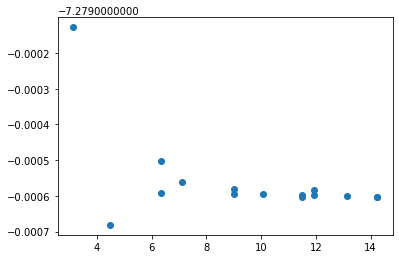

In [11]:
plt.scatter(x, y)

In [76]:
1

1